# Dependencies

In [2]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import shutil
import struct
from IPython.display import Image

try: 
    from urllib.request import urlretrieve 
except ImportError: 
    from urllib import urlretrieve

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

%matplotlib inline

# Load data

In [3]:
# Functions to load MNIST images and unpack into train and test set.
# - loadData reads image data and formats into a 28x28 long array
# - loadLabels reads the corresponding labels data, 1 for each image
# - load packs the downloaded image and labels data into a combined format to be read later by 
#   CNTK text reader 

def loadData(src, cimg):
    print ('Downloading ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Done.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # Read magic number.
            if n[0] != 0x3080000:
                raise Exception('Invalid file: unexpected magic number.')
            # Read number of entries.
            n = struct.unpack('>I', gz.read(4))[0]
            if n != cimg:
                raise Exception('Invalid file: expected {0} entries.'.format(cimg))
            crow = struct.unpack('>I', gz.read(4))[0]
            ccol = struct.unpack('>I', gz.read(4))[0]
            if crow != 28 or ccol != 28:
                raise Exception('Invalid file: expected 28 rows/cols per image.')
            # Read data.
            res = np.fromstring(gz.read(cimg * crow * ccol), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, crow * ccol))

def loadLabels(src, cimg):
    print ('Downloading ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Done.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # Read magic number.
            if n[0] != 0x1080000:
                raise Exception('Invalid file: unexpected magic number.')
            # Read number of entries.
            n = struct.unpack('>I', gz.read(4))
            if n[0] != cimg:
                raise Exception('Invalid file: expected {0} rows.'.format(cimg))
            # Read labels.
            res = np.fromstring(gz.read(cimg), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, 1))

def try_download(dataSrc, labelsSrc, cimg):
    data = loadData(dataSrc, cimg)
    labels = loadLabels(labelsSrc, cimg)
    return np.hstack((data, labels))

# URLs for the train image and labels data
url_train_image = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
url_train_labels = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
num_train_samples = 60000

print("Downloading train data")
train = try_download(url_train_image, url_train_labels, num_train_samples)

url_test_image = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
url_test_labels = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
num_test_samples = 10000

print("Downloading test data")
test = try_download(url_test_image, url_test_labels, num_test_samples)

# Save the data files into a format compatible with CNTK text reader
def savetxt(filename, ndarray):
    dir = os.path.dirname(filename)

    if not os.path.exists(dir):
        os.makedirs(dir)

    if not os.path.isfile(filename):
        print("Saving", filename )
        with open(filename, 'w') as f:
            labels = list(map(' '.join, np.eye(10, dtype=np.uint).astype(str)))
            for row in ndarray:
                row_str = row.astype(str)
                label_str = labels[row[-1]]
                feature_str = ' '.join(row_str[:-1])
                f.write('|labels {} |features {}\n'.format(label_str, feature_str))
    else:
        print("File already exists", filename)

# Save the train and test files (prefer our default path for the data)
data_dir = os.path.join("data", "MNIST")

print ('Writing train text file...')
savetxt(os.path.join(data_dir, "Train-28x28_cntk_text.txt"), train)

print ('Writing test text file...')
savetxt(os.path.join(data_dir, "Test-28x28_cntk_text.txt"), test)

print('Done')

Done.
Done.
Done.
Done.
Writing train text file...
File already exists data\MNIST\Train-28x28_cntk_text.txt
Writing test text file...
File already exists data\MNIST\Test-28x28_cntk_text.txt
Done


# Load data

In [3]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

# Ensure the training and test data is generated and available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.
data_found = False
data_dir = os.path.join("data", "MNIST")
train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
if os.path.isfile(train_file) and os.path.isfile(test_file):
    data_found = True
if not data_found:
    raise ValueError("Please generate the data")
print("Data directory is {0}".format(data_dir))

Data directory is data\MNIST


# Visualize data

Image Label:  3


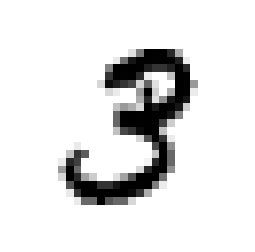

In [5]:
# Plot a random image
sample_number = 5001
plt.imshow(train[sample_number,:-1].reshape(28,28), cmap="gray_r")
plt.axis('off')
print("Image Label: ", train[sample_number,-1])

# Map out the neural net

In [4]:
input = C.input_variable((1, 28, 28))
label = C.input_variable(10)  # Probabilities for each number (0 - 9)

reader_train = create_reader(train_file, True, 784, 10)
input_map = {
    label  : reader_train.streams.labels,
    input  : reader_train.streams.features
}

with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.ops.relu):
    h = input / 255.0
    h = C.layers.Convolution2D(filter_shape = (5,5), 
                               num_filters = 8, 
                               strides = (2,2), 
                               pad = True,
                               name = 'first_conv')(h)
    h = C.layers.Convolution2D(filter_shape = (5,5), 
                               num_filters = 16, 
                               strides = (2,2), 
                               pad = True,
                               name = 'second_conv')(h)
    z = C.layers.Dense(10, activation = None, name = 'classify')(h)

loss = C.cross_entropy_with_softmax(z, label)
label_error = C.classification_error(z, label)

# Train the neural net

In [5]:
lr_schedule = C.learning_rate_schedule(0.2, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, label_error), [learner])

for i in range(0, int(60000 * 10 / 64)):
    data = reader_train.next_minibatch(64, input_map = input_map)
    trainer.train_minibatch(data)

# Test the neural net

In [6]:
reader_test = create_reader(test_file, False, 784, 10)
test_input_map = {
    label  : reader_test.streams.labels,
    input  : reader_test.streams.features,
}

test_result = 0.0
for i in range(10000 // 512):
    data = reader_test.next_minibatch(512, input_map = test_input_map)
    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

print("Average test error: {0:.2f}%".format(test_result*100 / (10000 // 512)))

Average test error: 1.39%


In [7]:
z.save('mnist')